<a href="https://colab.research.google.com/github/caesar013/PCVK_GENAP_2023/blob/main/Fikril_UTS_Jenio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
#from keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers import SGD
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from google.colab.patches import cv2_imshow
import imutils
from imutils.contours import sort_contours

In [ ]:
dataset_path = '/content/drive/MyDrive/PCVK/A_Z Handwritten Data.csv'
my_data = pd.read_csv(dataset_path).astype('float32')
my_frame = pd.DataFrame(my_data)
my_frame.head()

0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  ...  0.639  0.640  0.641  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   

   0.642  0.643  0.644  0.645  0.646  0.647  0.648  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 785 columns]

In [ ]:
x = my_frame.drop('0', axis = 1)
y = my_frame['0']

In [ ]:
# we are reshaping the train & test image data so that they can be displayed as an image,
# as initially in the CSV file they were present as 784 columns of pixel data. So we convert it to 28×28 pixels.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
x_train = np.reshape(x_train.values, (x_train.shape[0], 28, 28))
x_test = np.reshape(x_test.values, (x_test.shape[0], 28, 28))

print('Train Data Shape:', x_train.shape)
print('Test Data Shape:', x_test.shape)

Train Data Shape: (297960, 28, 28)
Test Data Shape: (74490, 28, 28)


In [ ]:
# Reshaping the training & test dataset so that it can be put in the model
# Now we reshape the train & test image dataset so that they can be put in the model.
# New shape of train data: (297960, 28, 28, 1)
# New shape of test data: (74490, 28, 28, 1)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
print("New shape of train data:", x_train.shape)

x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print("New shape of test data:", x_test.shape)

New shape of train data: (297960, 28, 28, 1)
New shape of test data: (74490, 28, 28, 1)


In [ ]:
# Here we convert the single float values to categorical values.
# This is done as the CNN model takes input of labels & generates the output as a vector of probabilities.

# What is CNN?
#   CNN stands for Convolutional Neural Networks
#   that are used to extract the features of the images using several layers of filters.

categorical_train = to_categorical(y_train, num_classes = 26, dtype = 'int')
print("New shape of train labels:", categorical_train.shape)

categorical_test = to_categorical(y_test, num_classes = 26, dtype = 'int')
print("New shape of test labels:", categorical_test.shape)

New shape of train labels: (297960, 26)
New shape of test labels: (74490, 26)


In [ ]:
# We have the Sequential model that we designed for training the model over the training dataset.
# The model created is as follows:

# Sequential() Model: A Sequential model is appropriate for a plain stack of layers
# where each layer has exactly one input tensor and one output tensor.

# MaxPool2D: The input along its spatial dimensions (height and width) by taking the maximum value over an input window
#(of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension.

my_model = Sequential()

my_model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
my_model.add(MaxPool2D(pool_size = (2, 2), strides = 2))

my_model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
my_model.add(MaxPool2D(pool_size = (2, 2), strides = 2))

my_model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'valid'))
my_model.add(MaxPool2D(pool_size = (2, 2), strides = 2))

my_model.add(Flatten())

my_model.add(Dense(64, activation = "relu"))
my_model.add(Dense(128, activation = "relu"))

my_model.add(Dense(26, activation = "softmax"))

In [ ]:
# 1): Here we are compiling the model, where we define the optimizing function & the loss function to be used for fitting.
# 2): The optimizing function used is Adam, that is a combination of RMSprop & Adagram optimizing algorithms.
# 3): The dataset is very large so we are training for only a single epoch,
#     however, as required we can even train it for multiple epochs
#     (which is recommended for character recognition for better accuracy).

my_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = my_model.fit(x_train, categorical_train, epochs = 10 , validation_data = (x_test, categorical_test))

Epoch 1/10
9312/9312 [==============================] - 60s 6ms/step - loss: 0.1654 - accuracy: 0.9548 - val_loss: 0.1144 - val_accuracy: 0.9683
Epoch 2/10
9312/9312 [==============================] - 48s 5ms/step - loss: 0.0736 - accuracy: 0.9796 - val_loss: 0.0852 - val_accuracy: 0.9761
Epoch 3/10
9312/9312 [==============================] - 49s 5ms/step - loss: 0.0615 - accuracy: 0.9832 - val_loss: 0.0655 - val_accuracy: 0.9824
Epoch 4/10
9312/9312 [==============================] - 53s 6ms/step - loss: 0.0552 - accuracy: 0.9851 - val_loss: 0.0660 - val_accuracy: 0.9833
Epoch 5/10
9312/9312 [==============================] - 51s 5ms/step - loss: 0.0525 - accuracy: 0.9860 - val_loss: 0.0653 - val_accuracy: 0.9839
Epoch 6/10
9312/9312 [==============================] - 48s 5ms/step - loss: 0.0514 - accuracy: 0.9865 - val_loss: 0.0536 - val_accuracy: 0.9866
Epoch 7/10
9312/9312 [==============================] - 48s 5ms/step - loss: 0.0479 - accuracy: 0.9876 - val_loss: 0.0724 - val_ac

In [ ]:
my_model.save('/content/drive/MyDrive/PCVK/model_hand.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/PCVK/model_hand.h5')

# Function

In [11]:
import cv2
# Define function for contour detection
def find_contours(img):
  conts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  conts = imutils.grab_contours(conts)
  conts = sort_contours(conts, method='left-to-right')[0]

  return conts

def biggest_contour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 1000:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.015 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest

def rotate(images, img):
  rotate_clockwise = [0,1,2,3,4,14]
  rotate_counterclockwise = [5,6,7,8,9,11,13]
  if(i in rotate_clockwise):
    images[i] = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
  elif(i in rotate_counterclockwise):
    images[i] = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
  elif(i == 12):
    images[i] = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    images[i] = cv2.rotate(images[i], cv2.ROTATE_90_CLOCKWISE)
def extract_roi(img, x, y, w, h):
    roi = img[y:y+h, x:x+w]
    return roi

def process_box(gray, x, y, w, h):
    roi = extract_roi(gray, x, y, w, h)
    thresh = thresholding(roi)
    (h, w) = thresh.shape
    resized = resize_img(thresh, w, h)
    normalized = normalization(resized)
    return (normalized, (x, y, w, h))

def thresholding(img):
    thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    return thresh

def resize_img(img, w, h):
    if w > h:
        resized = imutils.resize(img, width=28)
    else:
        resized = imutils.resize(img, height=28)
    (h, w) = resized.shape

    dX = int(max(0, 28 - w) / 2.0)
    dY = int(max(0, 28 - h) / 2.0)

    filled = cv2.copyMakeBorder(resized, top=dY, bottom=dY, right=dX, left=dX, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
    filled = cv2.resize(filled, (28, 28))

    return filled

def normalization(img):
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

def cut_image(img, ind):
  img = cv2.rotate(img.copy(), cv2.ROTATE_90_COUNTERCLOCKWISE)
  if(ind == 0):
    img = img[950:1750, 1400:2900] #jenio 1
  elif(ind == 1):
    img = img[950:1600, 1490:2700] #jenio 2 (I)nformarika
  elif(ind == 2):
    img = img[1350:2100, 1350:2870] #jenio 3 (I)nformarika, G(I)an
  elif(ind == 3):
    img = img[1200:1880, 2280:3350] #jenio 4 (I)nformarika, Dw(I)
  elif(ind == 4):
    img = img[1200:1860, 1050:2200] #jenio 5(I)nformarika, Dw(I), (2)

  return img

def preprocess(img):
  img = img.copy()
  gaussian_blur = cv2.GaussianBlur(img, (1, 1), 1)
  Z = gaussian_blur.reshape((-1,3))
  # convert to np.float32
  Z = np.float32(Z)
  # define criteria, number of clusters(K) and apply kmeans()
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 2
  ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
  # Now convert back into uint8, and make original image
  center = np.uint8(center)
  res = center[label.flatten()]
  res2 = res.reshape((img.shape))

  closing = cv2.morphologyEx(res2, cv2.MORPH_CLOSE, np.ones((3,3), dtype=np.uint8), iterations=2)
  # erode = cv2.dilate(opening, np.ones((3,3),np.uint8), 1)
  se = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3) )
  dilated_image = cv2.dilate(closing.copy(), se)
  gray = cv2.cvtColor(dilated_image.copy(), cv2.COLOR_BGR2GRAY)
  _, thresholded_image = cv2.threshold(gray.copy(), 100, 255, cv2.THRESH_BINARY)
  invert = 255 - thresholded_image
  cv2_imshow(invert)
  return invert, gray

def process(img, inverted_img, gray):
  contours_data = []
  contours_data = find_contours(inverted_img.copy())

  min_w, max_w = 10, 160
  min_h, max_h = 14, 140
  img_copy = img.copy()

  detected_char = []

  for c in contours_data:
    (x, y, w, h) = cv2.boundingRect(c)

    if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
      detected_char.append(process_box(gray, x, y, w, h))
      roi = gray.copy()[y:y+h, x:x+w]
      th = cv2.threshold(roi, 0,255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

  pixels = np.array([px[0] for px in detected_char], dtype='float32')
  boxes = [box[1] for box in detected_char]

  digits = '0123456789'
  letters = 'ABCDEFGHIJKLMNOPQRSTUVWZYZ'
  char_list = digits + letters
  char_list = [ch for ch in char_list]

  preds = model.predict(pixels)

  for (pred, (x, y, w, h)) in zip(preds, boxes):
      i = np.argmax(pred)
      char_detected = char_list[i]

      cv2.rectangle(img_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
      cv2.putText(img_copy, char_detected, (x - 10, y - 10), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 0, 0), 2)

  cv2_imshow(img_copy)

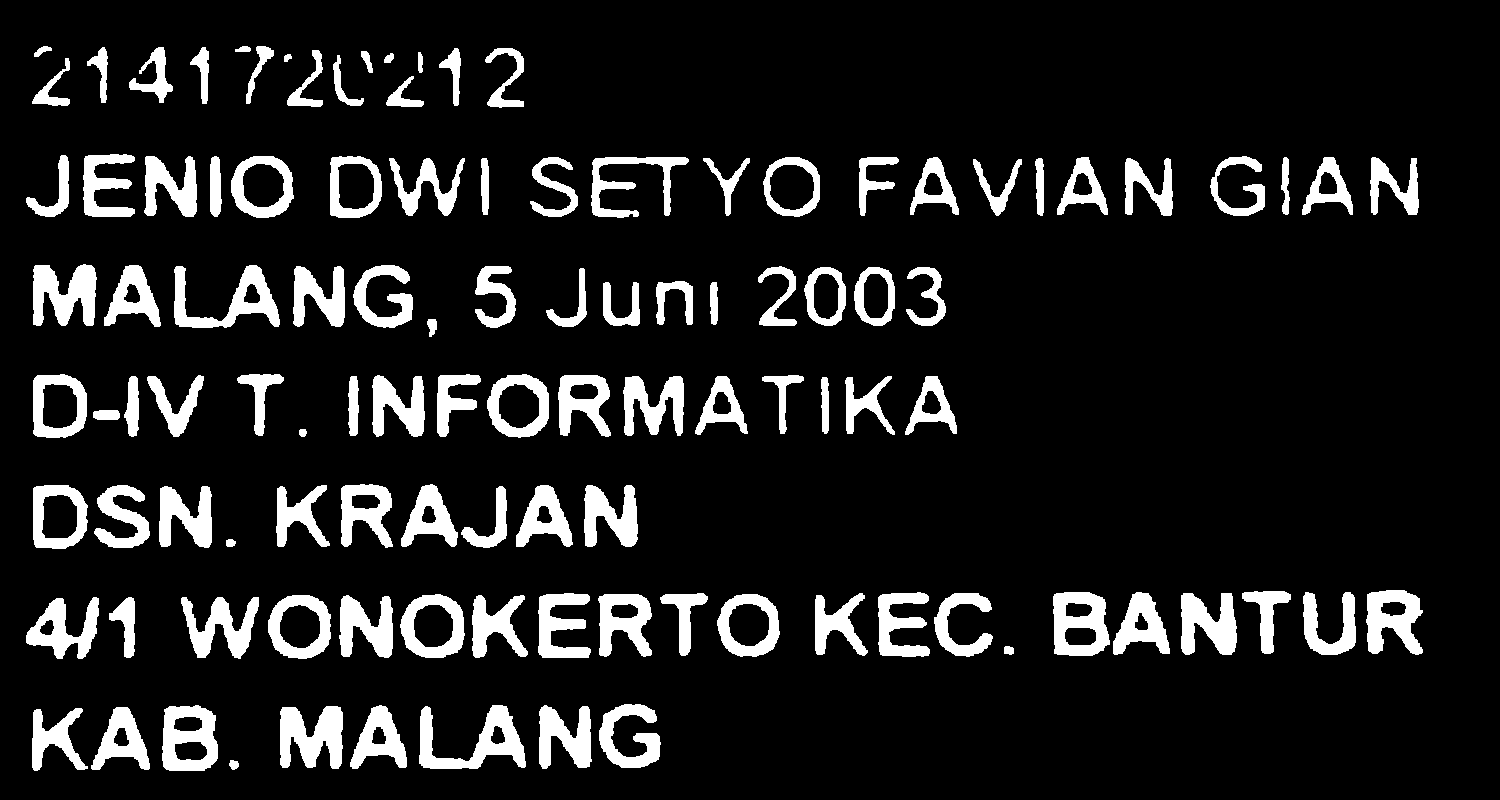

3/3 [==============================] - 2s 79ms/step


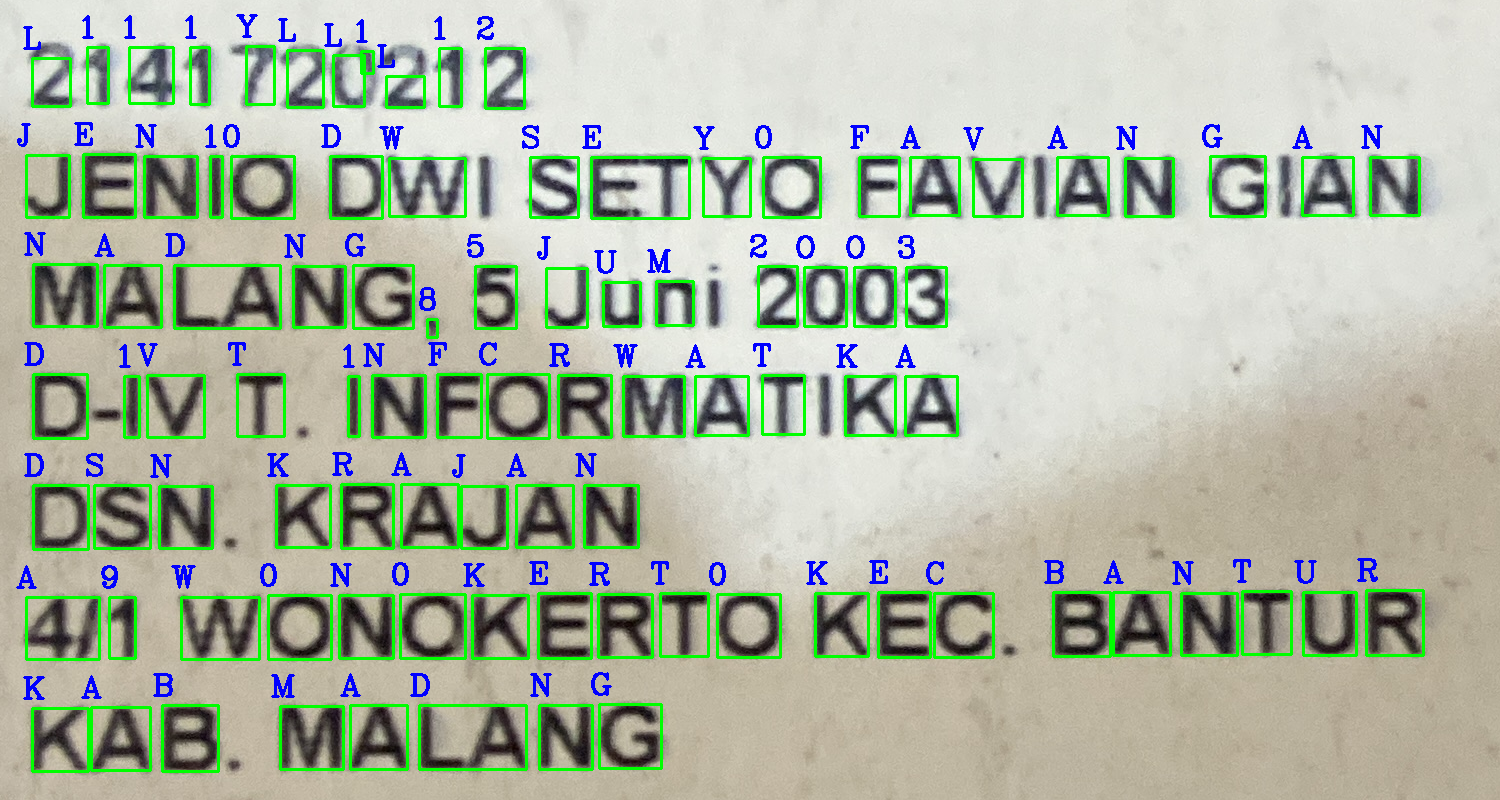

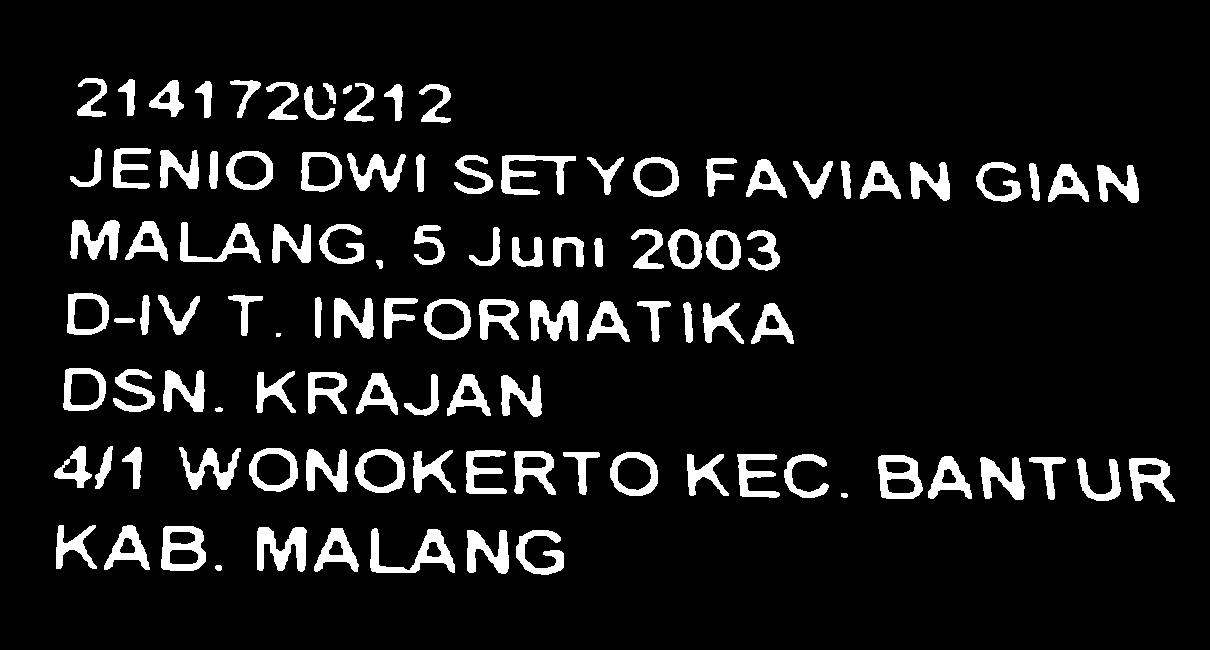

3/3 [==============================] - 0s 6ms/step


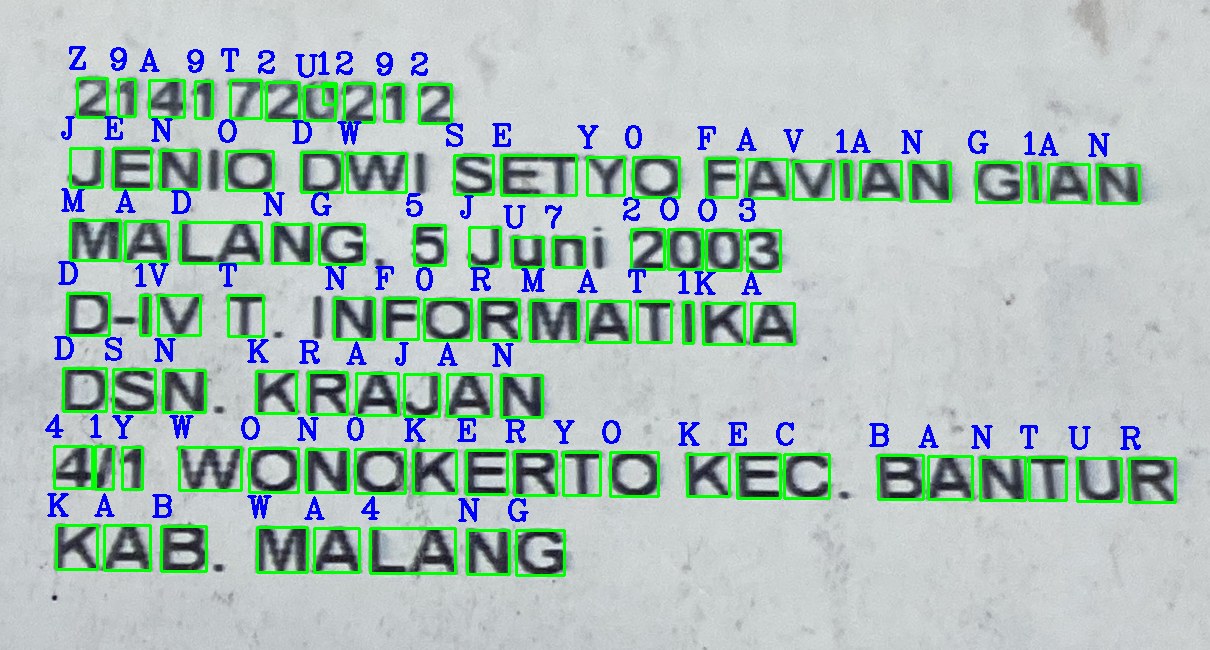

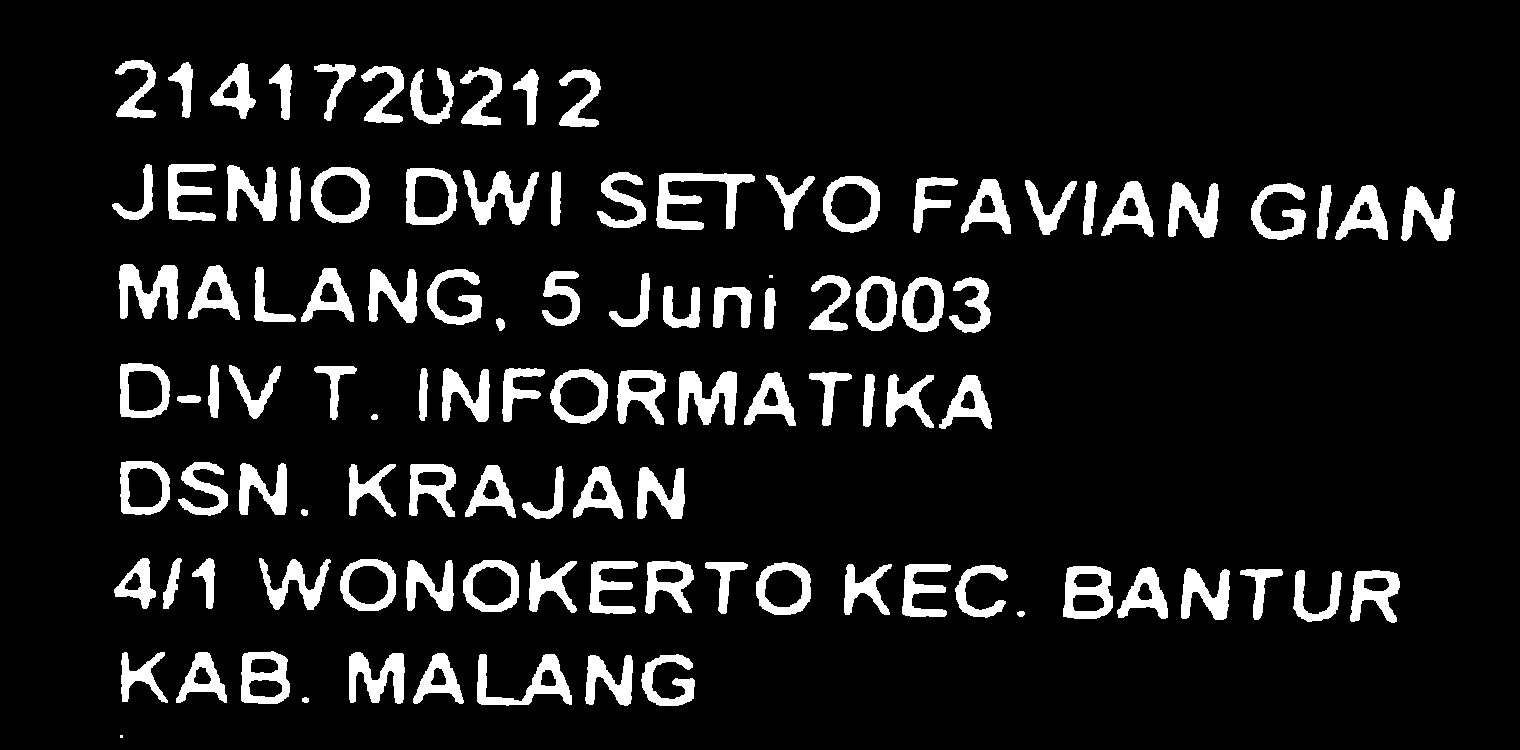

4/4 [==============================] - 0s 71ms/step


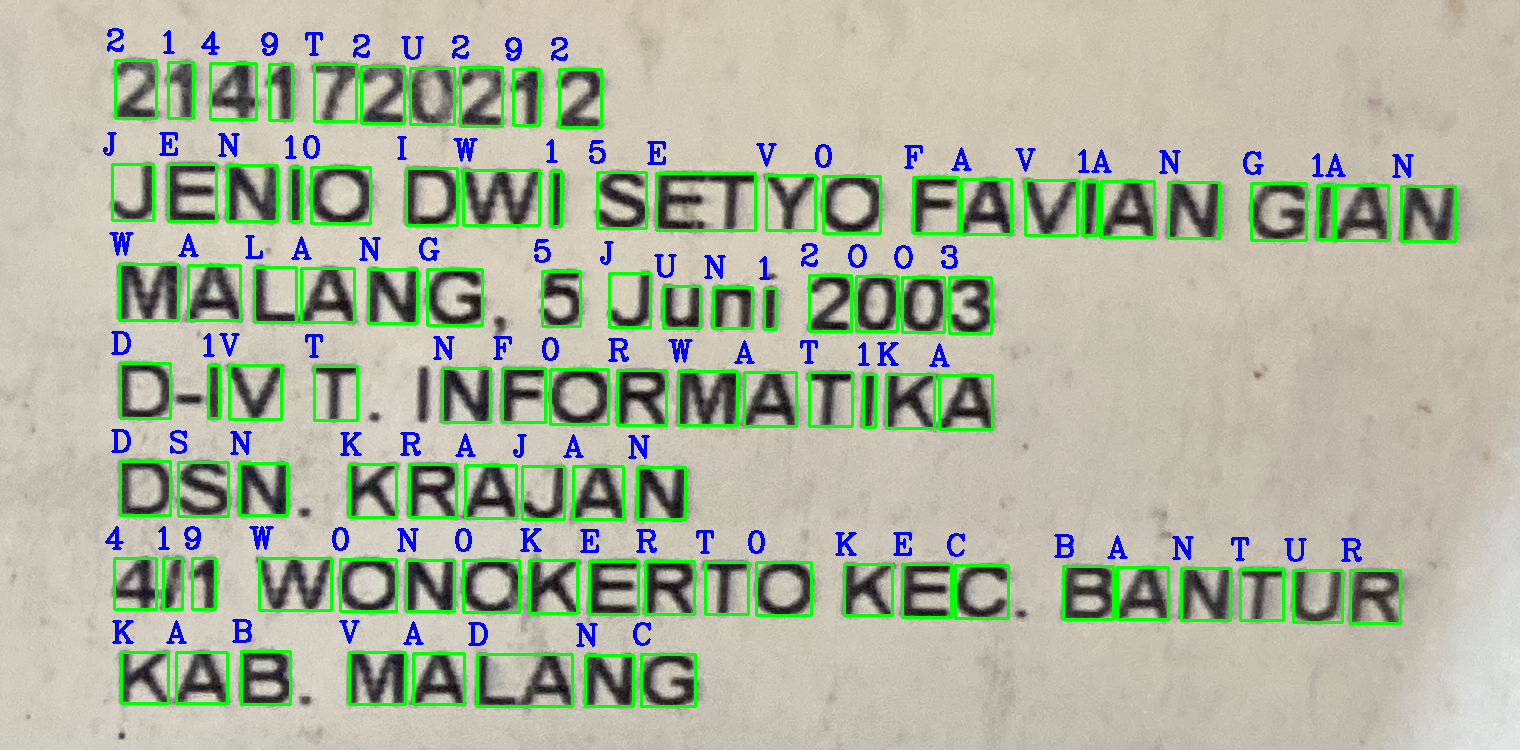

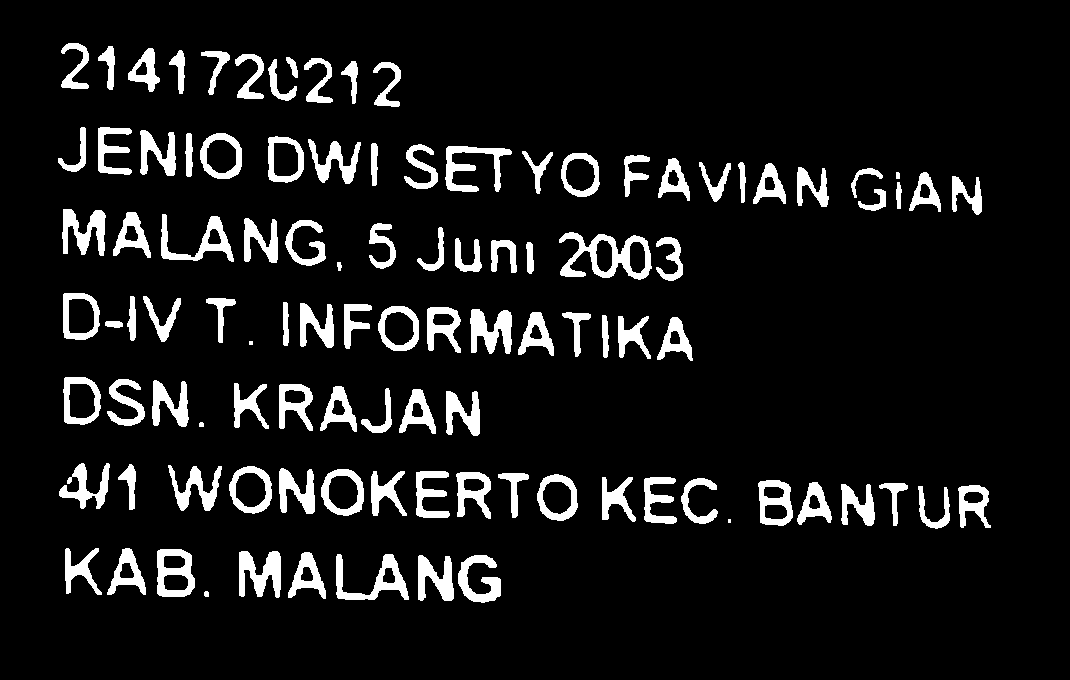

3/3 [==============================] - 0s 86ms/step


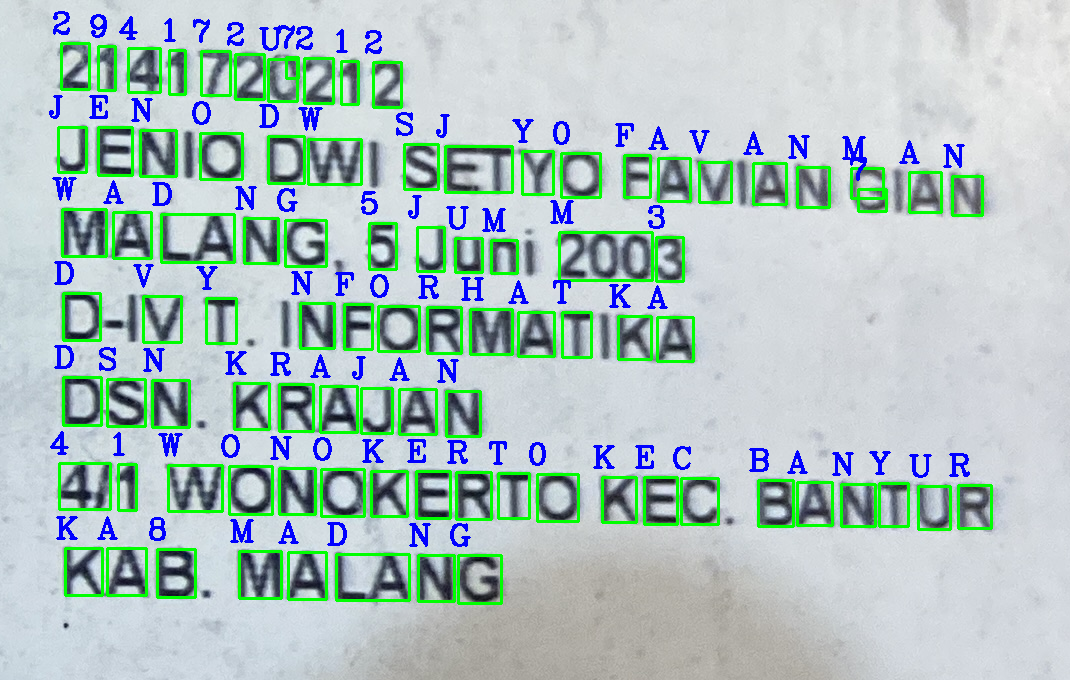

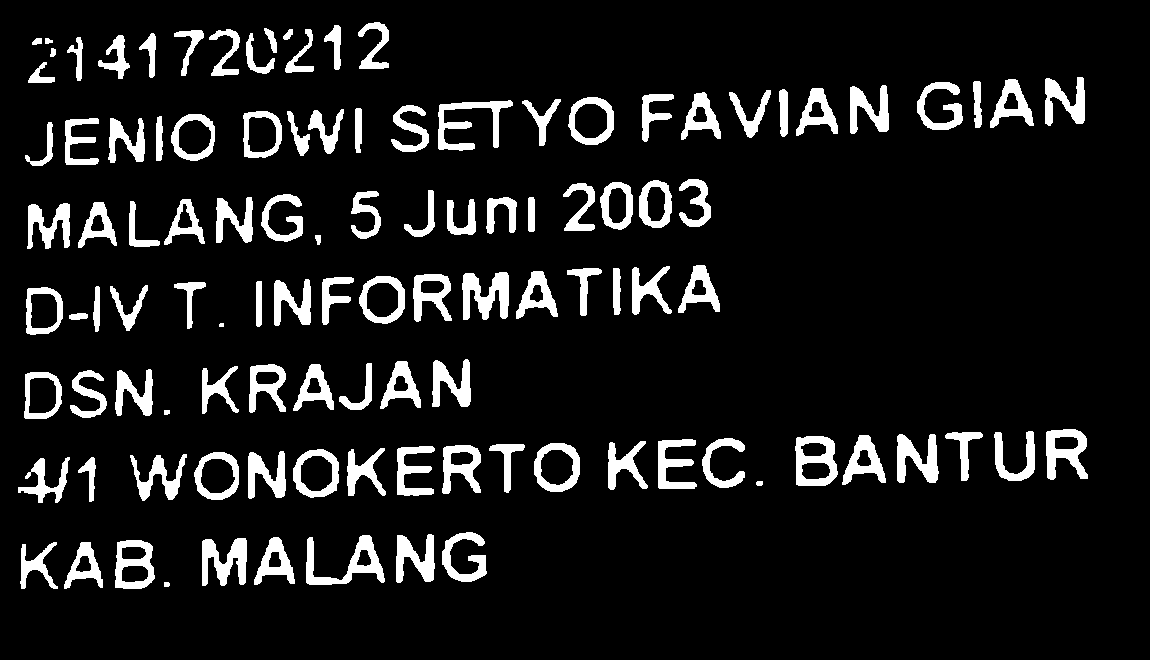

3/3 [==============================] - 0s 82ms/step


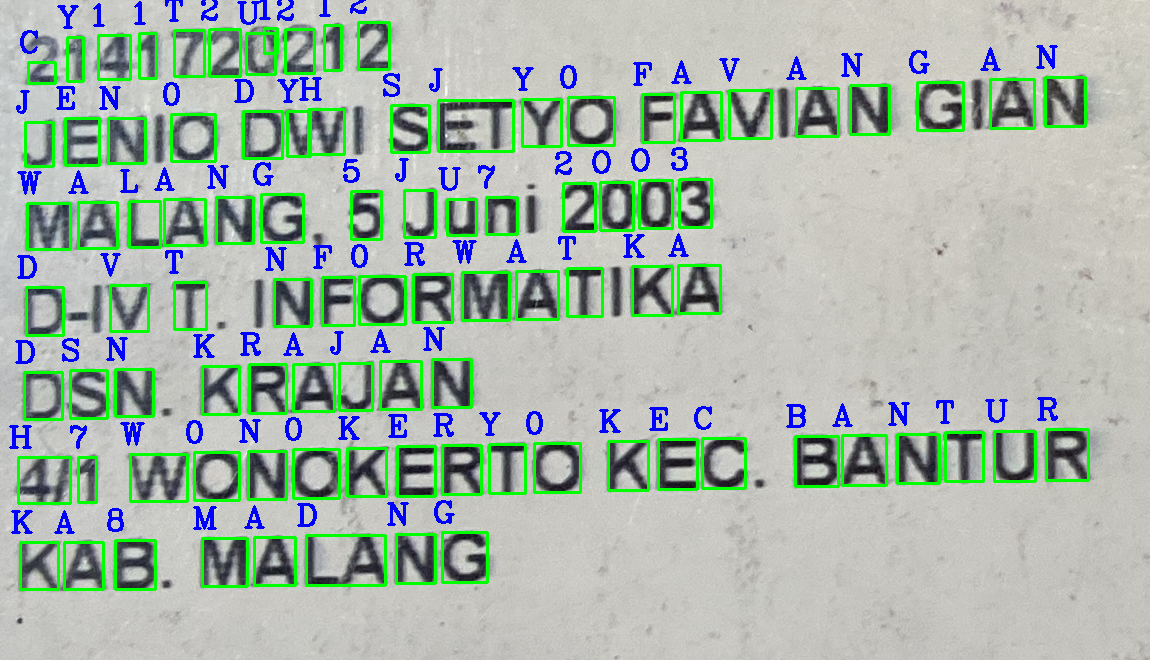

In [12]:
image_paths = [
'/content/drive/MyDrive/PCVK/Images/Kelompok 7/3F_2141720212_1 - JENIO DWI SETYO FAVIAN GIAN.JPG',
'/content/drive/MyDrive/PCVK/Images/Kelompok 7/3F_2141720212_2 - JENIO DWI SETYO FAVIAN GIAN.JPG',
'/content/drive/MyDrive/PCVK/Images/Kelompok 7/3F_2141720212_3 - JENIO DWI SETYO FAVIAN GIAN.JPG',
'/content/drive/MyDrive/PCVK/Images/Kelompok 7/3F_2141720212_4 - JENIO DWI SETYO FAVIAN GIAN.JPG',
'/content/drive/MyDrive/PCVK/Images/Kelompok 7/3F_2141720212_5 - JENIO DWI SETYO FAVIAN GIAN.JPG'
]

for i, img_path in enumerate(image_paths):
  img = cv2.imread(img_path)

  cut_img = cut_image(img, i)
  preprocess_img, gray = preprocess(cut_img)
  process(cut_img, preprocess_img, gray)


